In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data, make_model
from model import AEDist
import numpy as np
import os
import glob
import demap
from tqdm import tqdm
# from evaluation import compute_encoding_metrics, get_dataset_contents, get_noiseless_name, get_ambient_name, get_data_config, eval_results, compute_recon_metric
from evaluation import compute_all_metrics, get_noiseless_name, get_ambient_name
from transformations import NonTransform
import torch
import demap


In [2]:
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
# run_id = '2ez8uy5v'
# sweep_id = 'cxebx19g'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


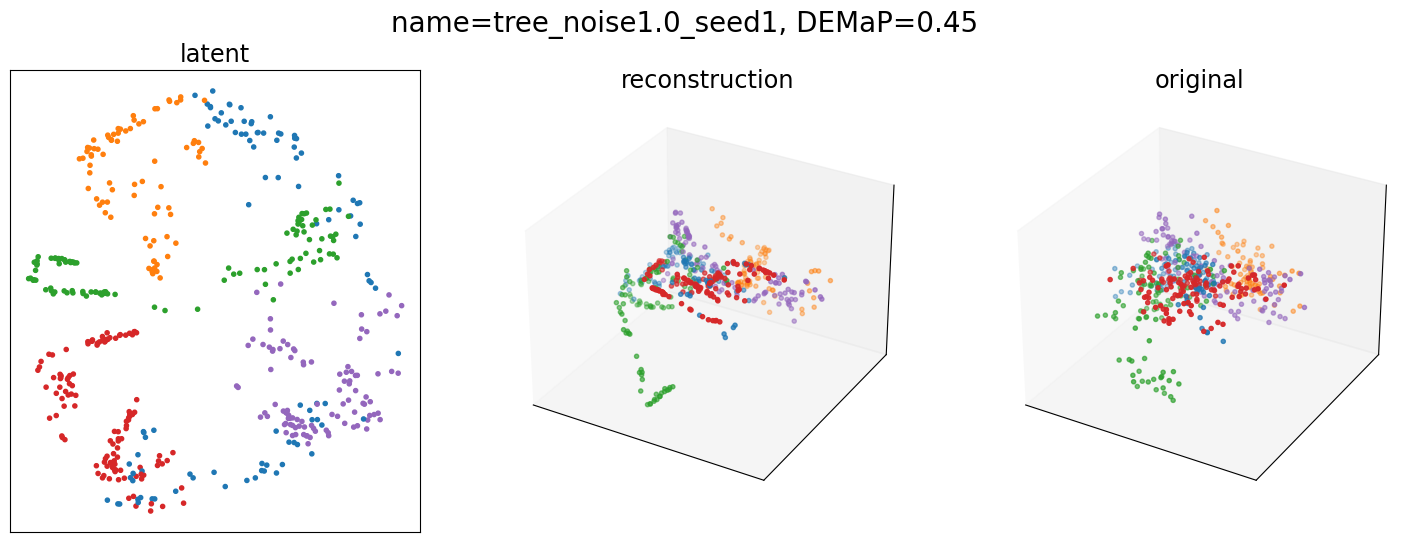

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


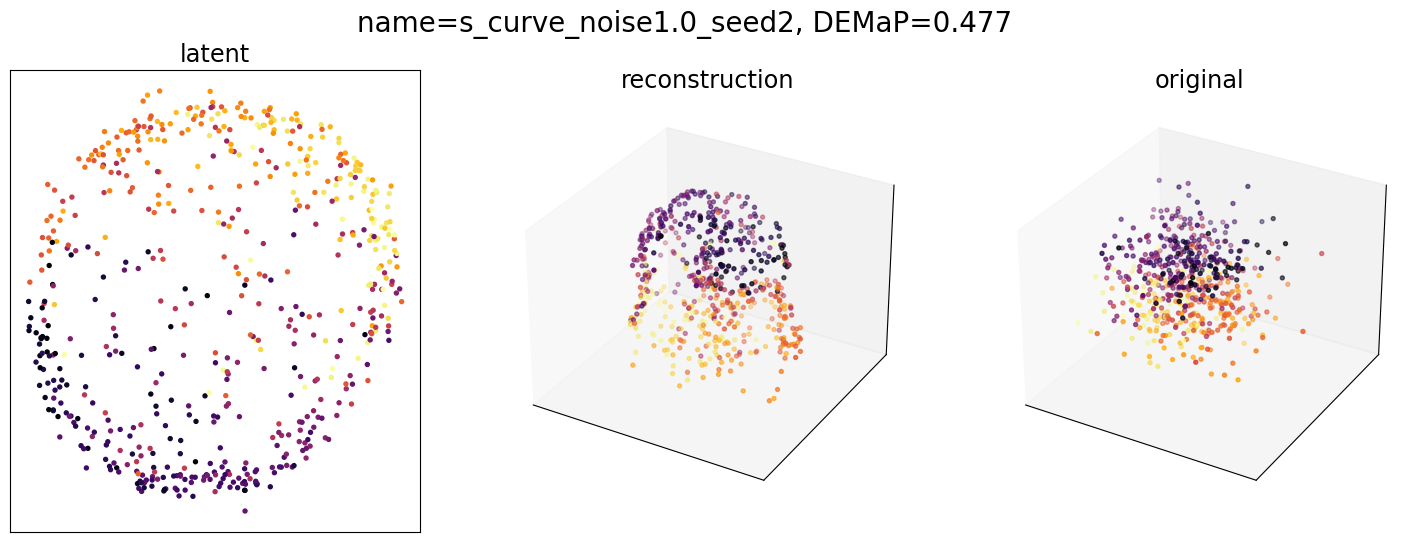

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


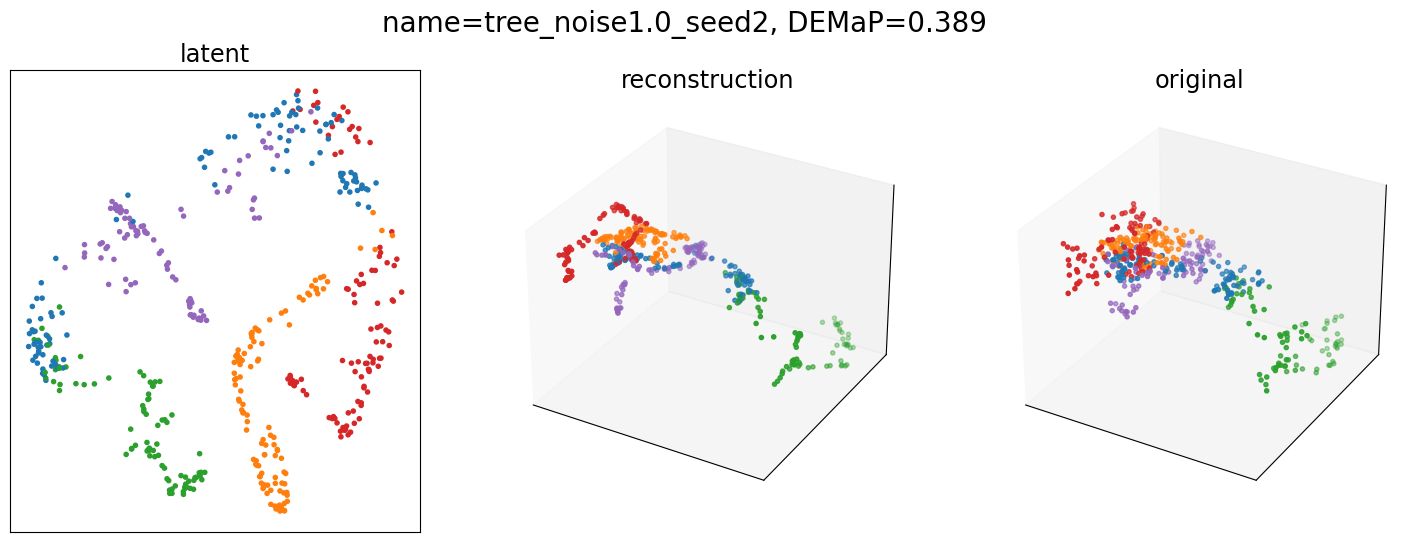

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


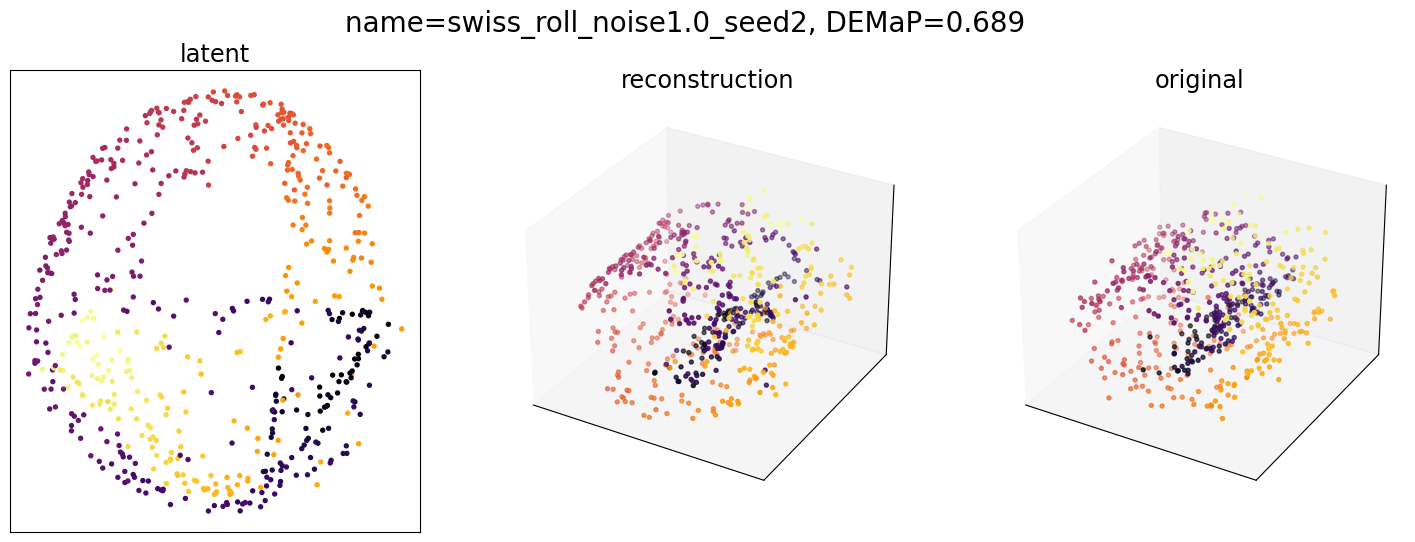

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


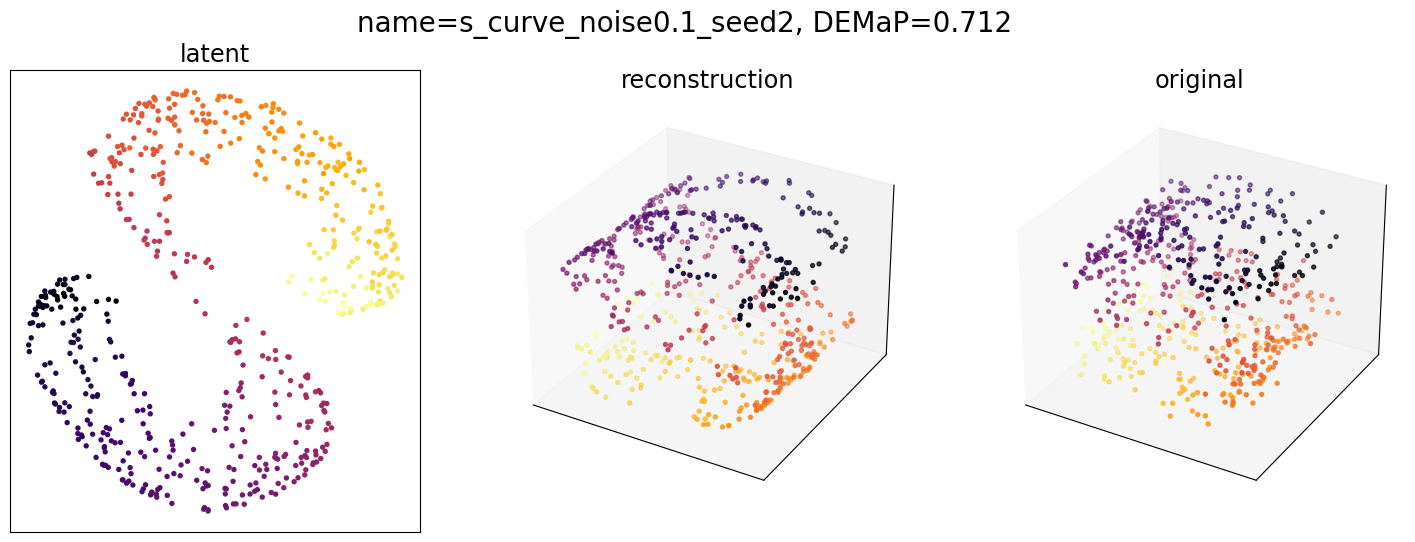

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


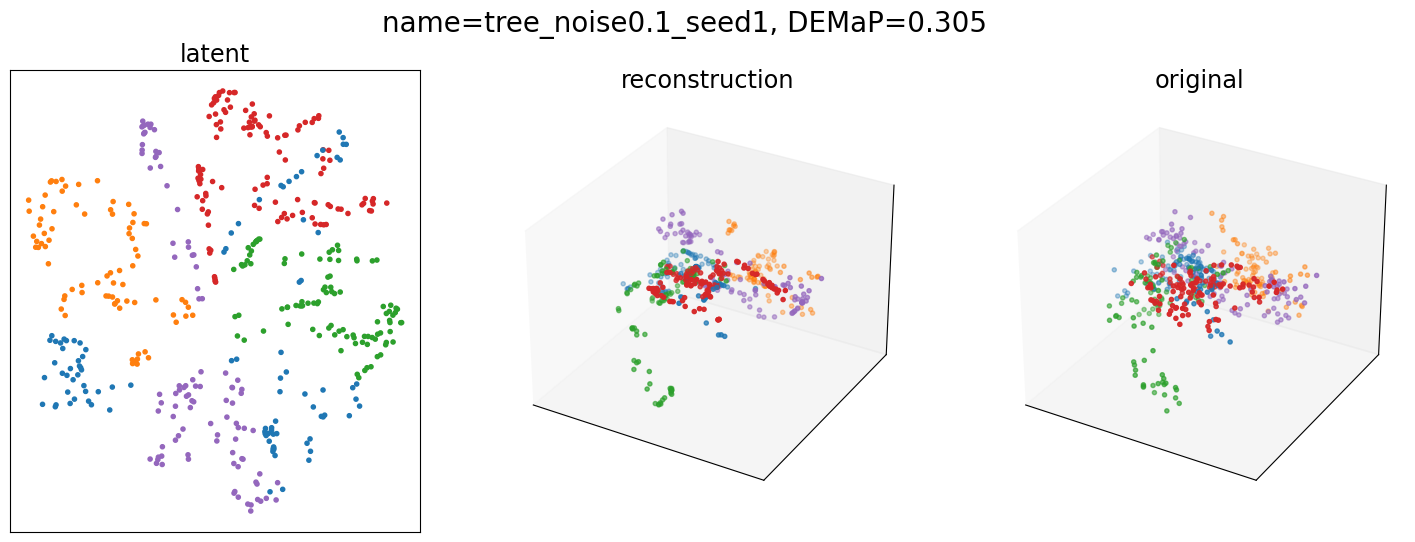

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


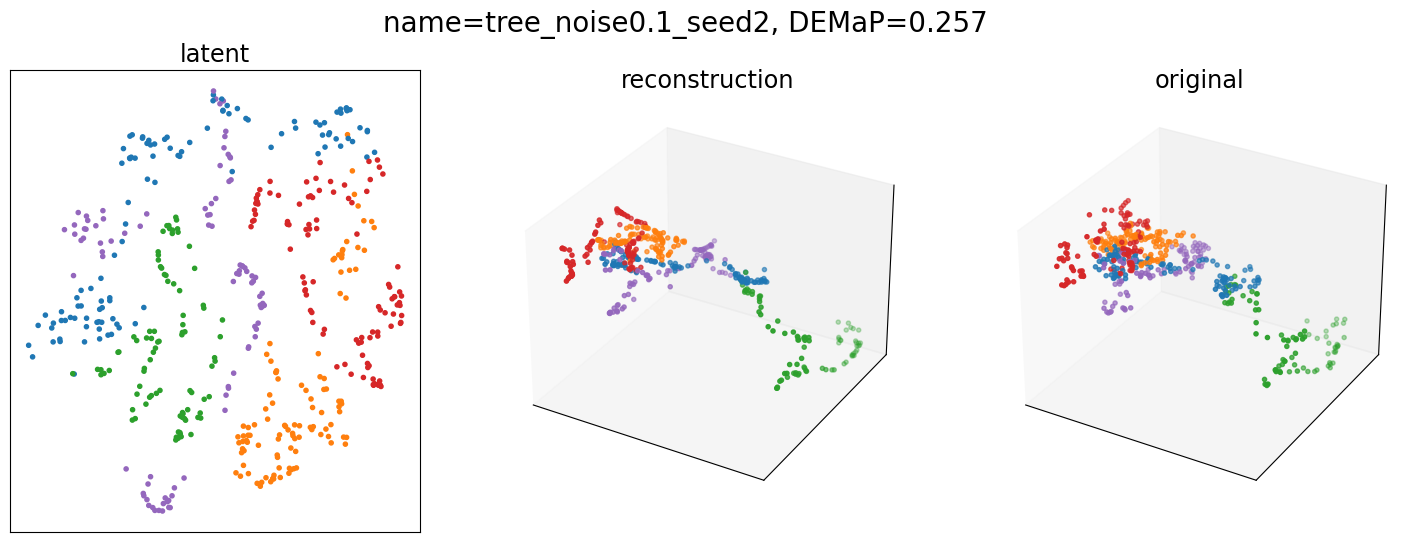

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


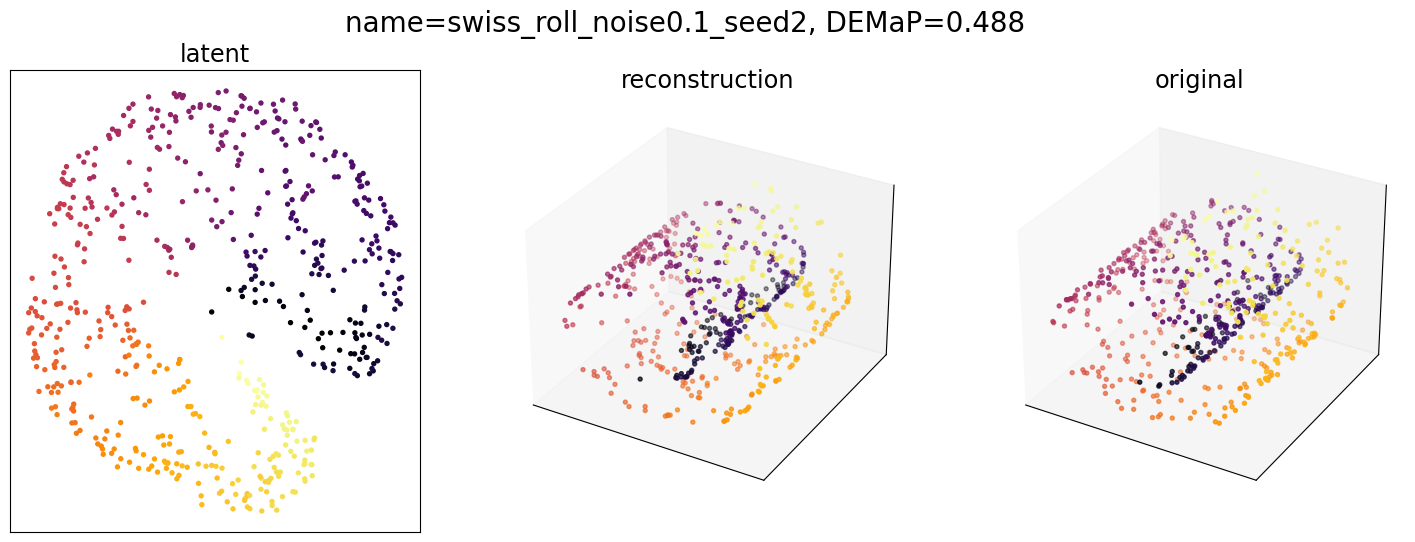

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


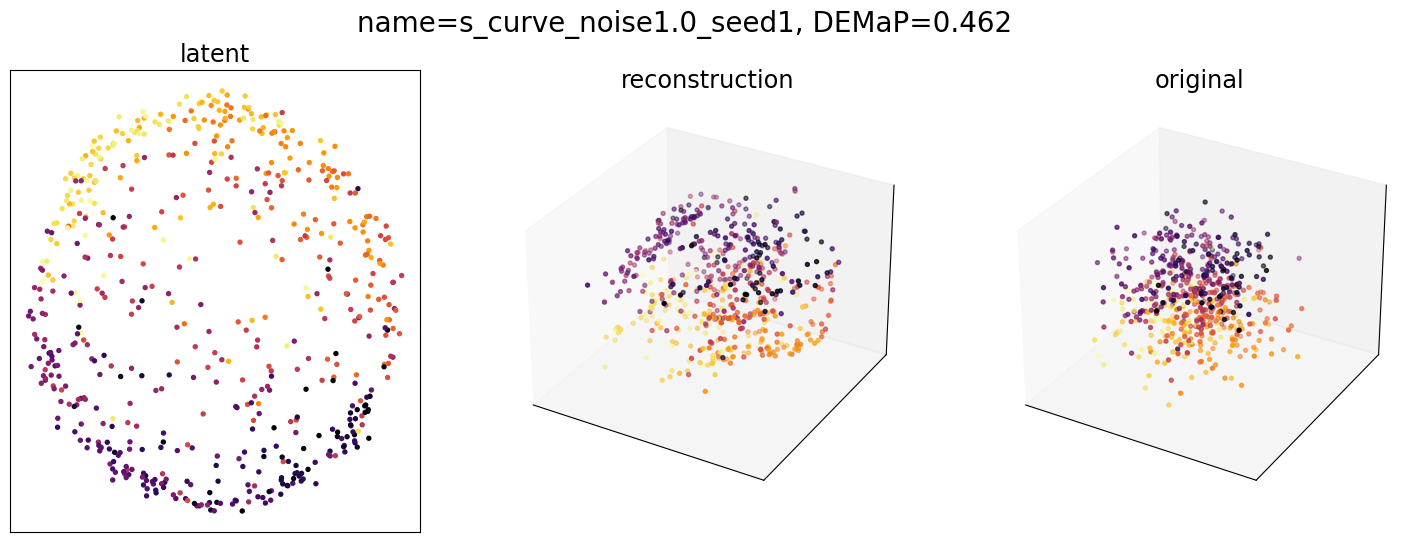

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


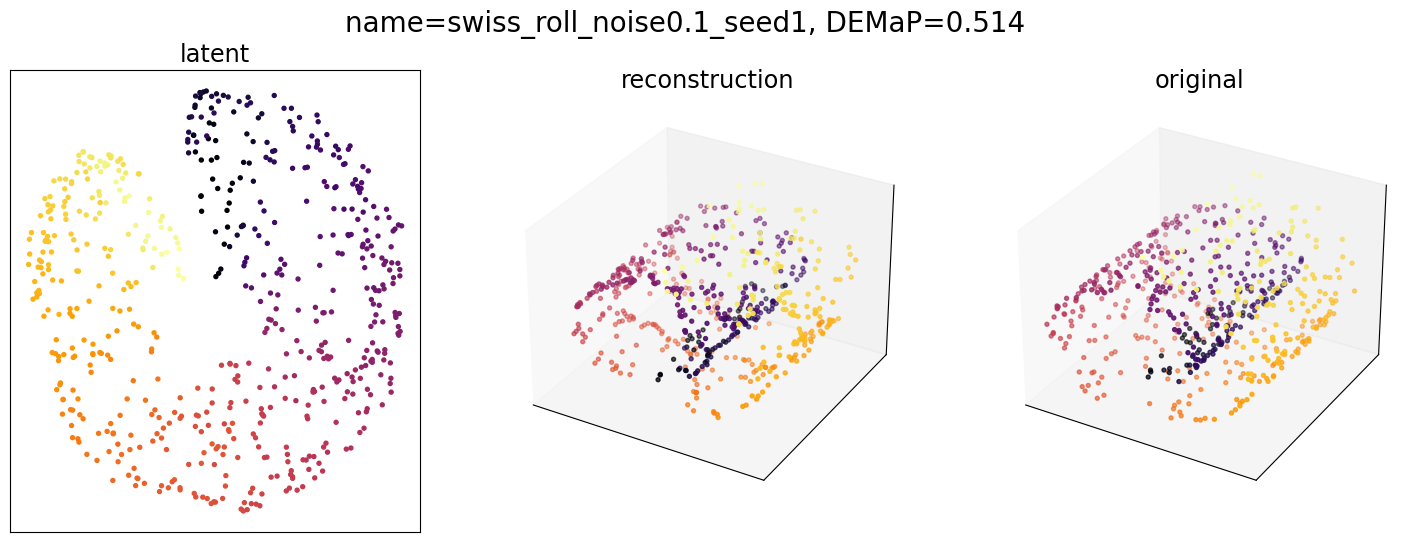

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


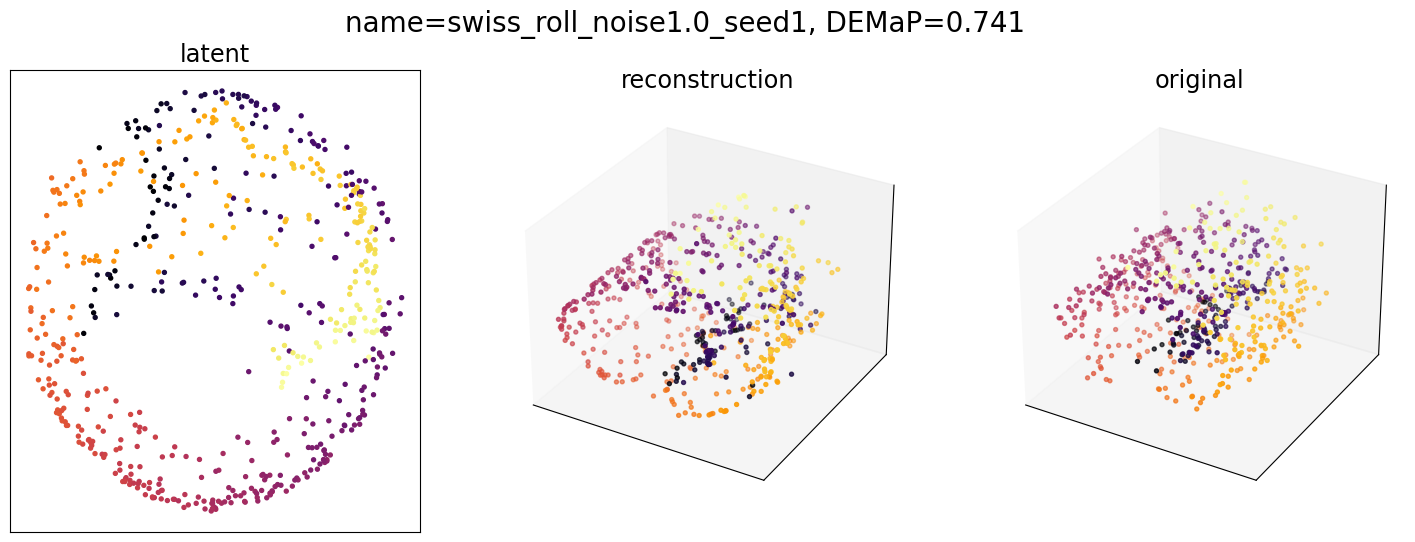

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


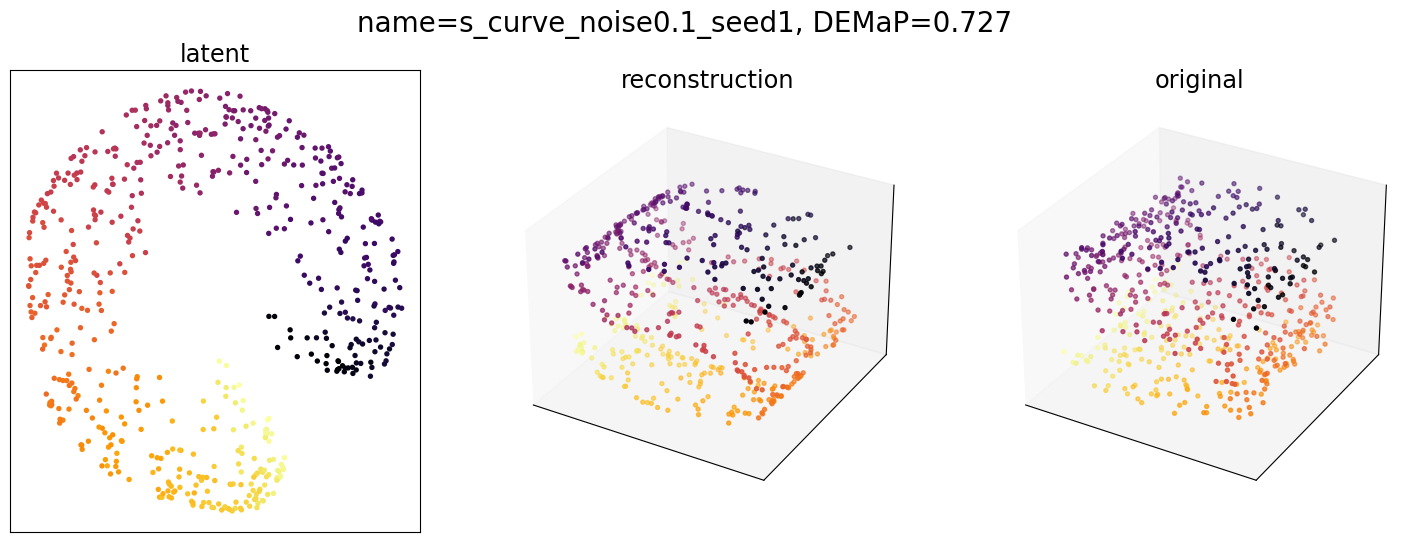

In [3]:
sweep_id = 'tfmof6b9' # landmark off

sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
res = []
for run in sweep.runs:
    cfg = OmegaConf.create(run.config)
    folder_path = "../src/wandb/"
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
    data = np.load(data_path, allow_pickle=True)
    model = AEDist.load_from_checkpoint(ckpt_path)
    x_tensor = torch.tensor(data['data'][~data['is_train'].astype(bool)], dtype=torch.float32, device=model.device)
    colors = data['colors'][~data['is_train'].astype(bool)]
    x_true = data['data_gt'][~data['is_train'].astype(bool)]
    with torch.no_grad():
        z = model.encode(x_tensor)
        xh = model.decode(z)
    demap_val = demap.DEMaP(x_true, z.cpu().numpy())
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131)
    scprep.plot.scatter2d(z.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax1, title='latent')
    ax2 = fig.add_subplot(132, projection='3d')
    scprep.plot.scatter3d(xh.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax2, title='reconstruction')
    ax3 = fig.add_subplot(133, projection='3d')
    scprep.plot.scatter3d(x_tensor.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax3, title='original')
    plt.suptitle(f'name={cfg.data.name}, DEMaP={np.round(demap_val, 3)}', fontsize=20)
    plt.show()
    res_dict = dict(
        name=cfg.data.name,
        DEMaP=demap_val
    )
    res.append(res_dict)

In [4]:
res_df_no_landmark = pd.DataFrame(res)

In [5]:
res_df_no_landmark.sort_values('name')

name     DEMaP
11     s_curve_noise0.1_seed1  0.727128
4      s_curve_noise0.1_seed2  0.712069
8      s_curve_noise1.0_seed1  0.461945
1      s_curve_noise1.0_seed2  0.477196
9   swiss_roll_noise0.1_seed1  0.514161
7   swiss_roll_noise0.1_seed2  0.487512
10  swiss_roll_noise1.0_seed1  0.740897
3   swiss_roll_noise1.0_seed2  0.689039
5         tree_noise0.1_seed1  0.305216
6         tree_noise0.1_seed2  0.257076
0         tree_noise1.0_seed1  0.450479
2         tree_noise1.0_seed2  0.389079

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


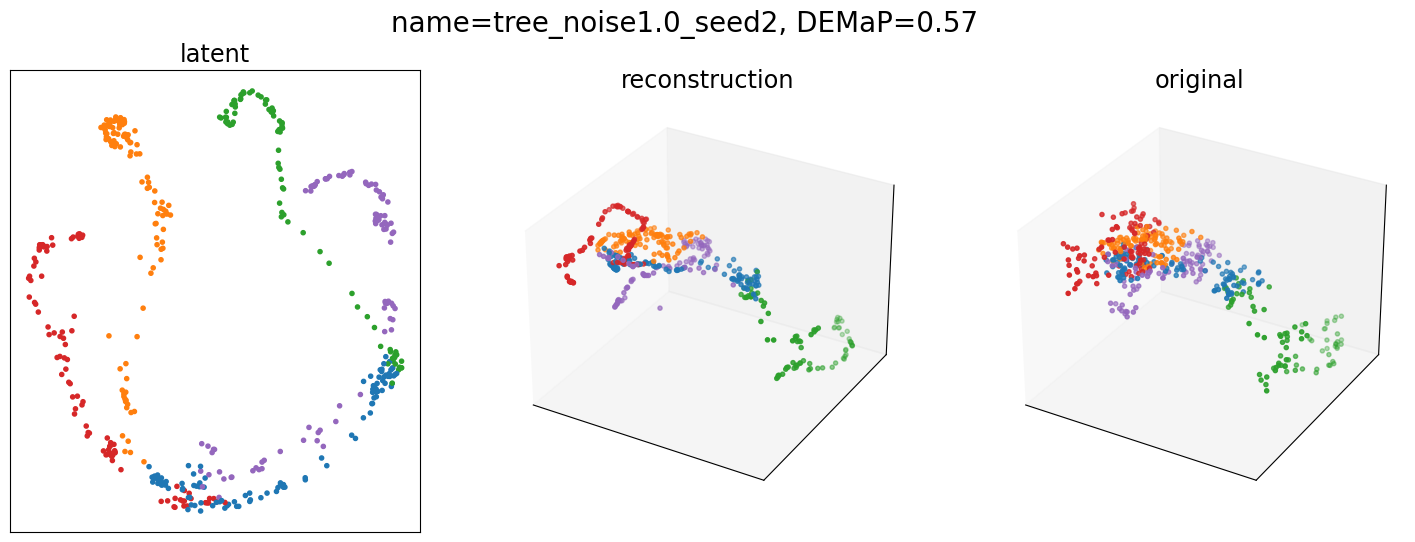

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


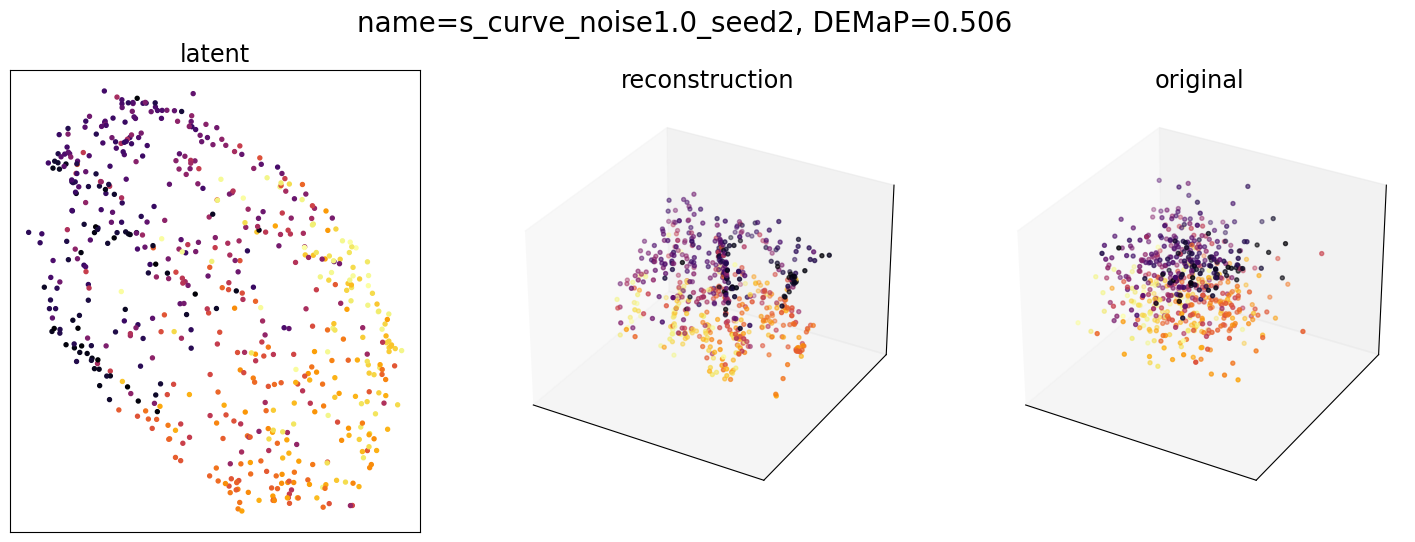

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


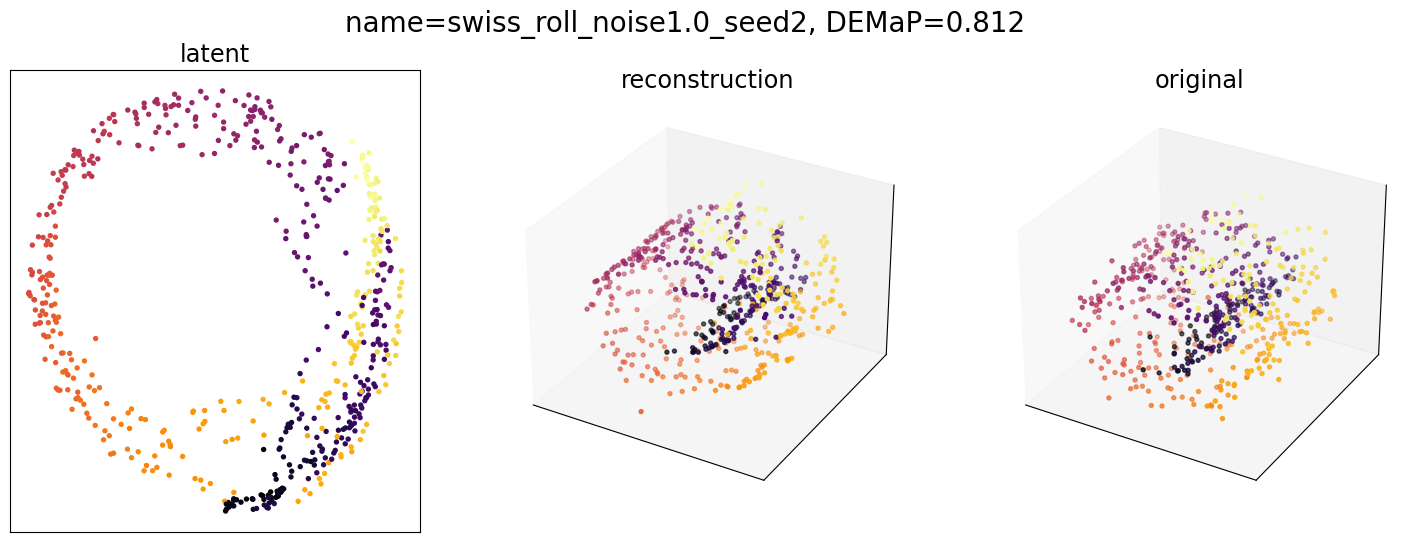

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


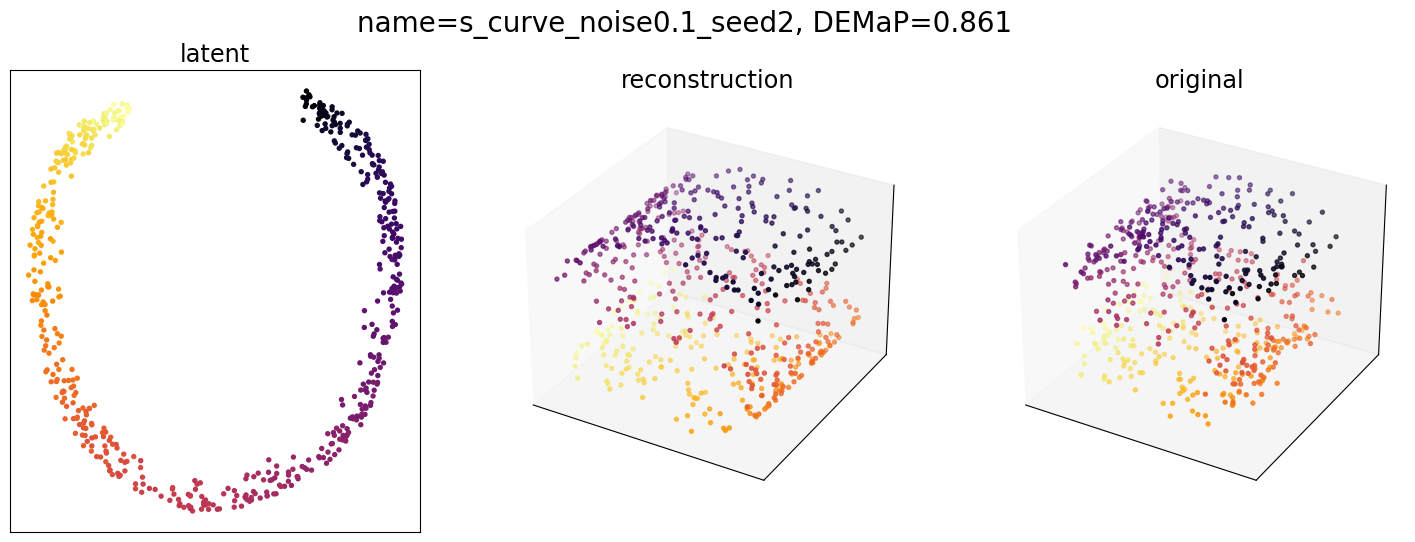

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


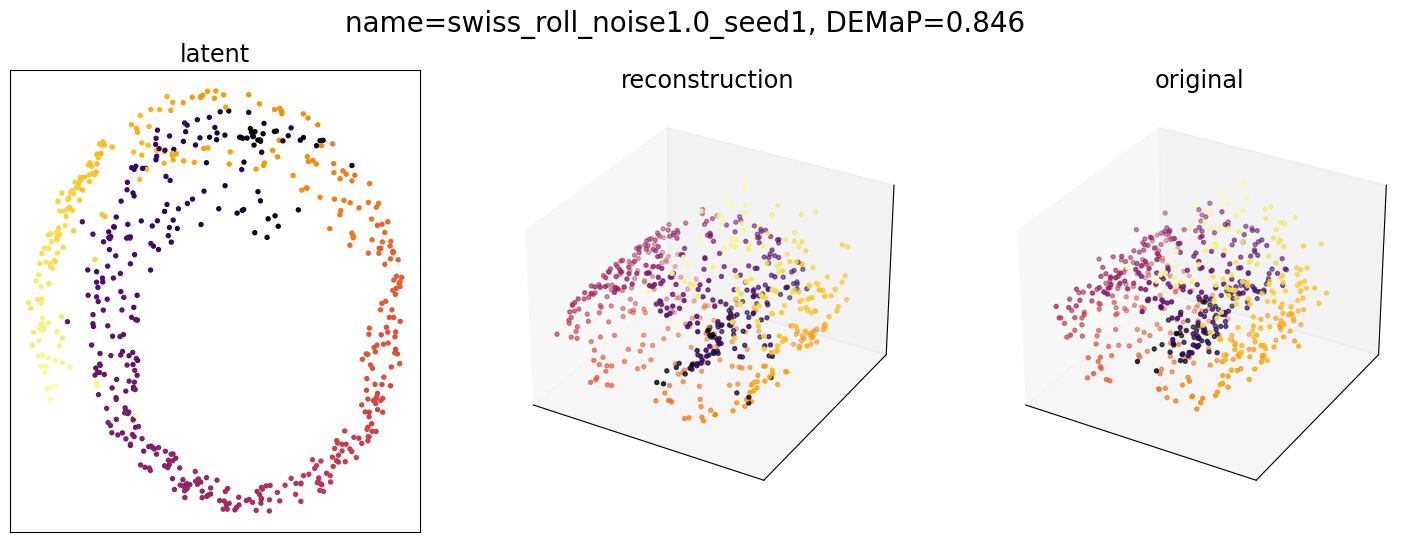

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


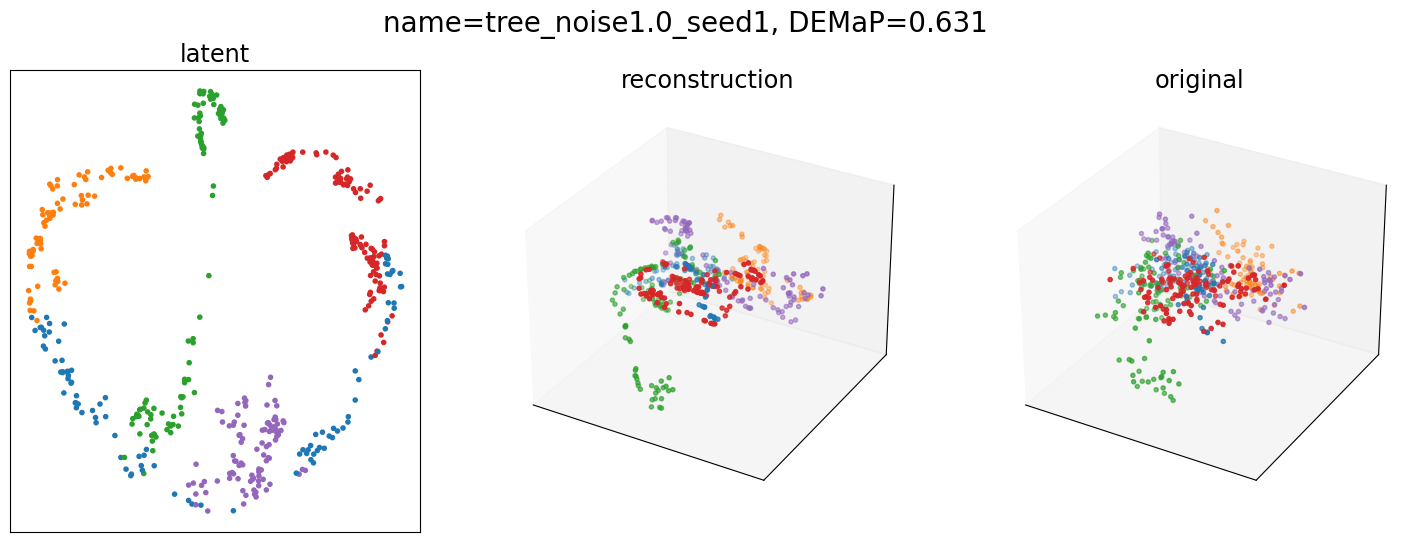

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


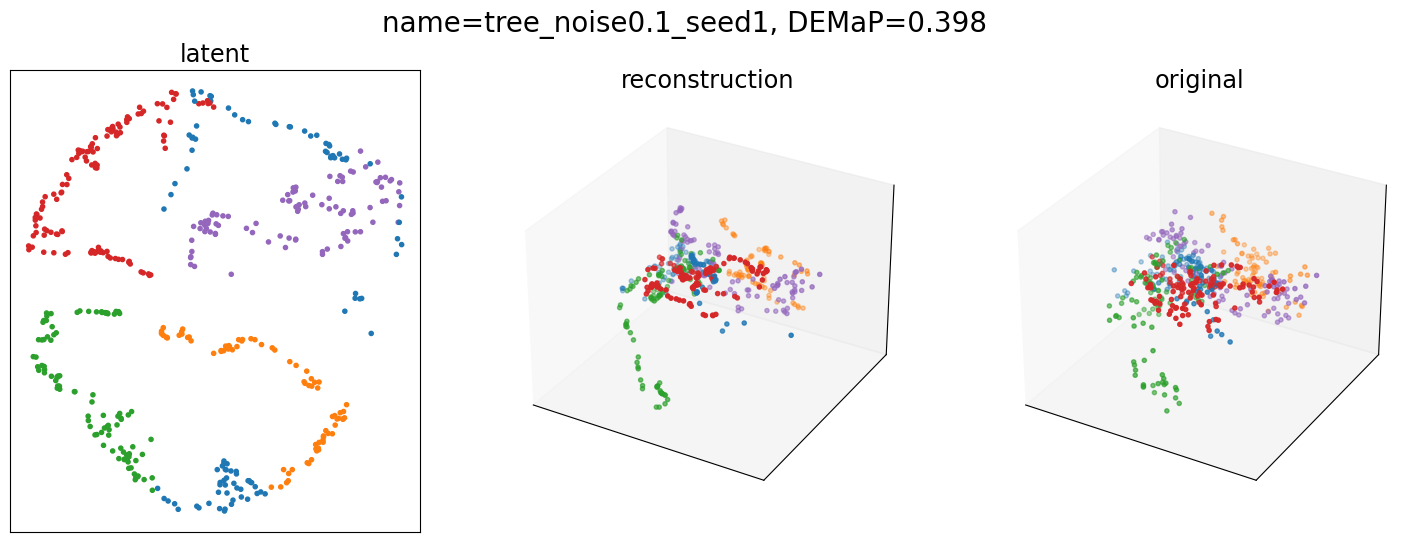

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


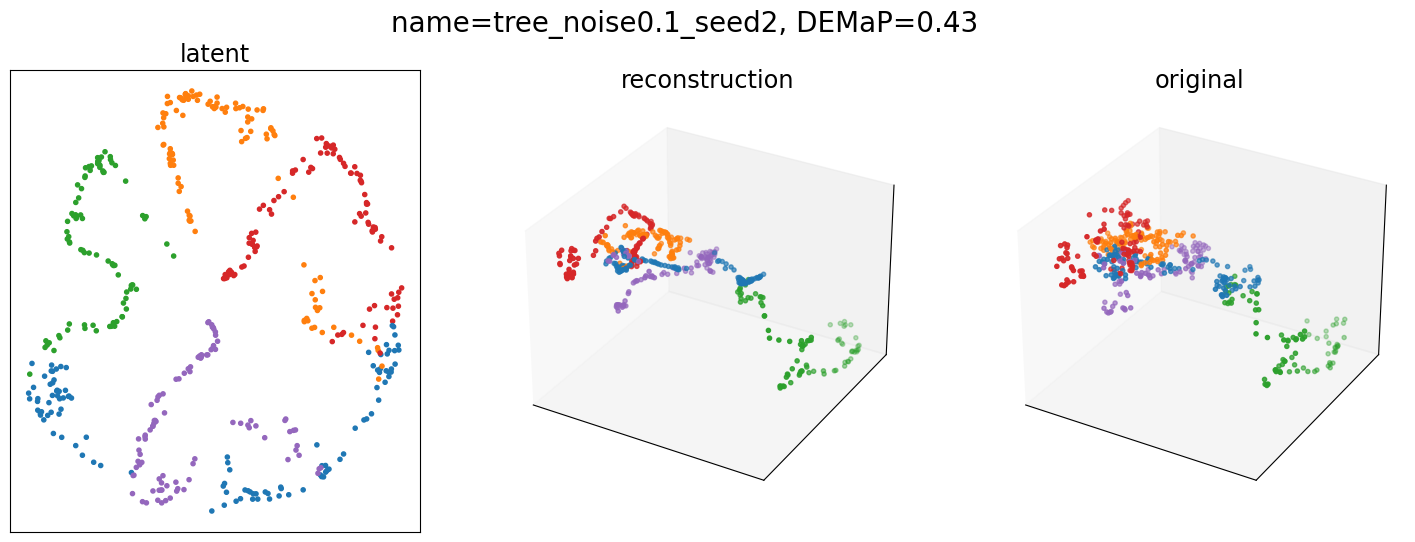

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


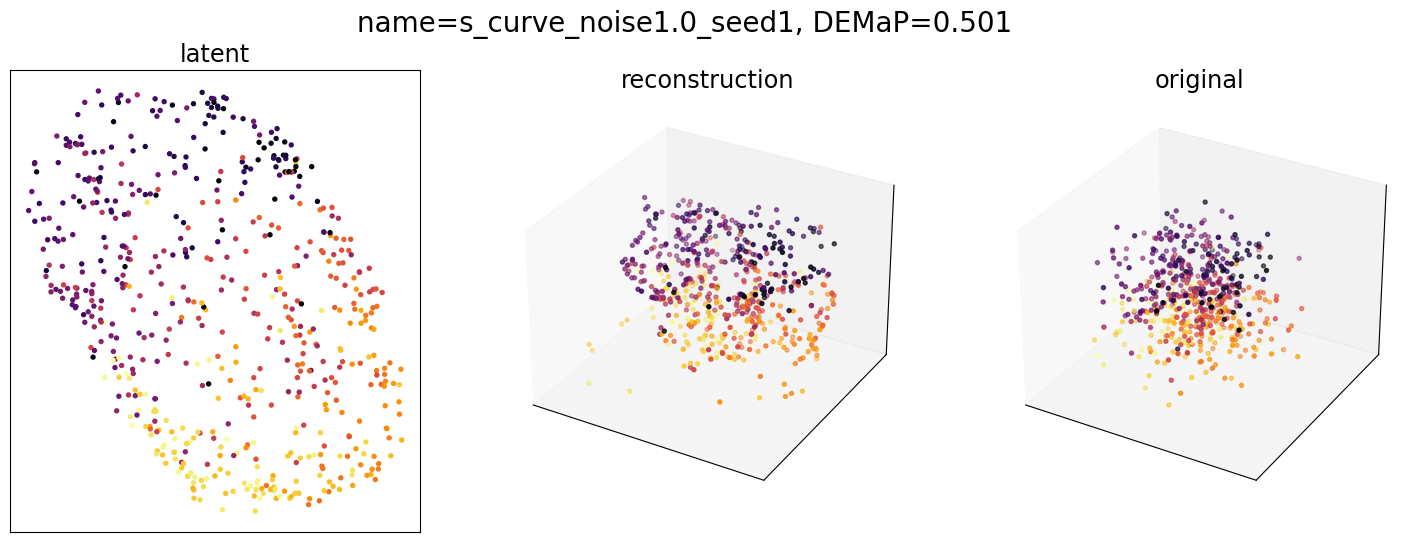

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


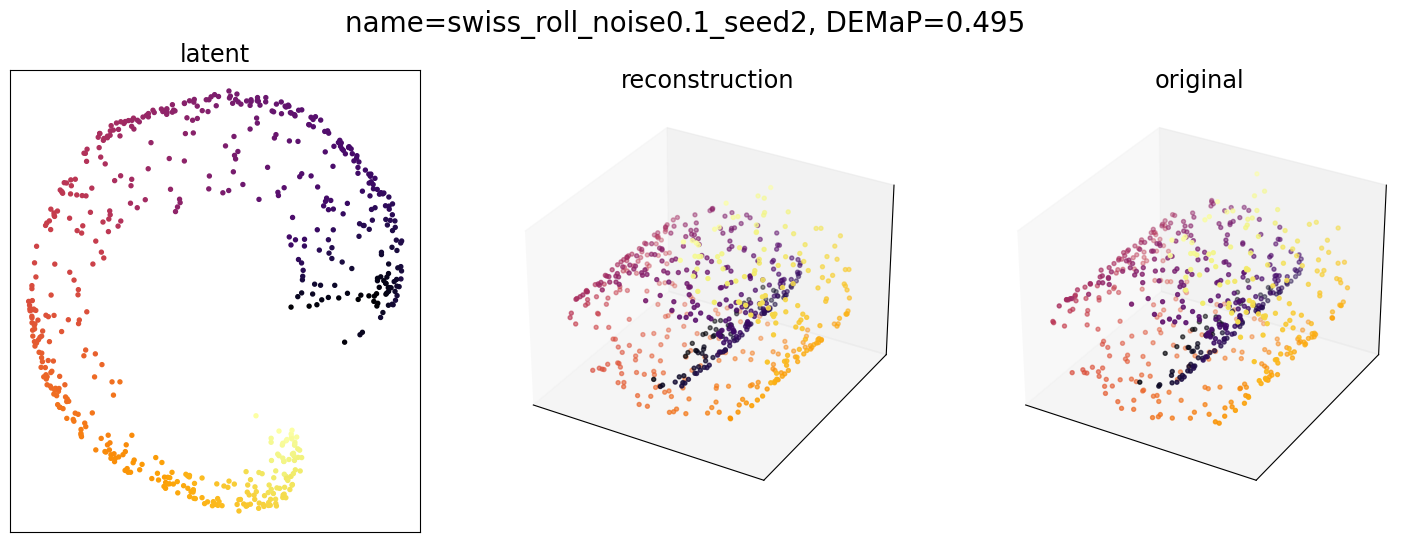

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


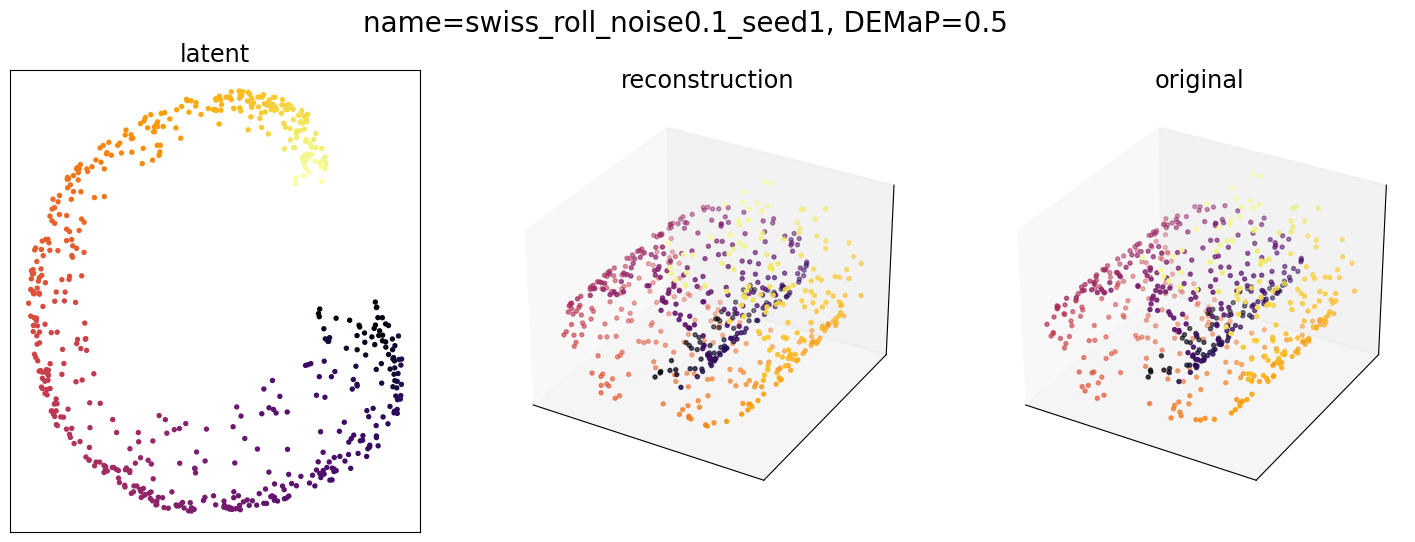

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


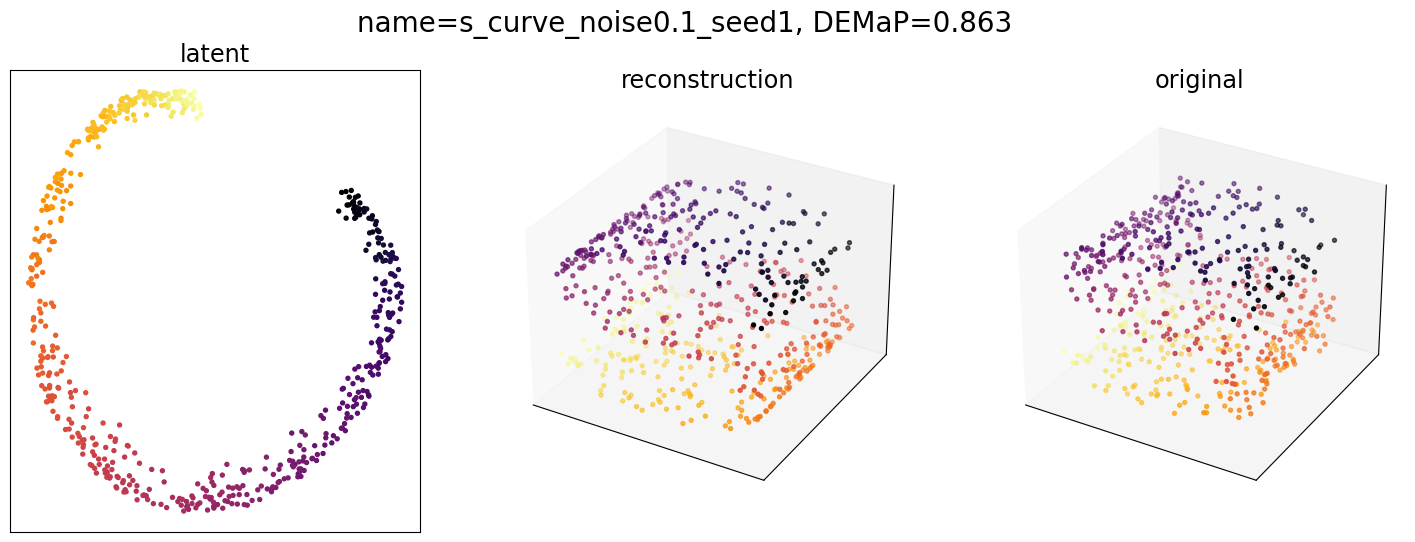

In [6]:
sweep_id = '4kj9hz6w' # landmark on

sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
res = []
for run in sweep.runs:
    cfg = OmegaConf.create(run.config)
    folder_path = "../src/wandb/"
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
    data = np.load(data_path, allow_pickle=True)
    model = AEDist.load_from_checkpoint(ckpt_path)
    x_tensor = torch.tensor(data['data'][~data['is_train'].astype(bool)], dtype=torch.float32, device=model.device)
    colors = data['colors'][~data['is_train'].astype(bool)]
    x_true = data['data_gt'][~data['is_train'].astype(bool)]
    with torch.no_grad():
        z = model.encode(x_tensor)
        xh = model.decode(z)
    demap_val = demap.DEMaP(x_true, z.cpu().numpy())
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131)
    scprep.plot.scatter2d(z.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax1, title='latent')
    ax2 = fig.add_subplot(132, projection='3d')
    scprep.plot.scatter3d(xh.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax2, title='reconstruction')
    ax3 = fig.add_subplot(133, projection='3d')
    scprep.plot.scatter3d(x_tensor.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax3, title='original')
    plt.suptitle(f'name={cfg.data.name}, DEMaP={np.round(demap_val, 3)}', fontsize=20)
    plt.show()
    res_dict = dict(
        name=cfg.data.name,
        DEMaP=demap_val
    )
    res.append(res_dict)

In [7]:
res_df_landmark = pd.DataFrame(res)

In [8]:
res_df_landmark.sort_values('name')

name     DEMaP
11     s_curve_noise0.1_seed1  0.863438
3      s_curve_noise0.1_seed2  0.860724
8      s_curve_noise1.0_seed1  0.501309
1      s_curve_noise1.0_seed2  0.505620
10  swiss_roll_noise0.1_seed1  0.499933
9   swiss_roll_noise0.1_seed2  0.495141
4   swiss_roll_noise1.0_seed1  0.846469
2   swiss_roll_noise1.0_seed2  0.812114
6         tree_noise0.1_seed1  0.398402
7         tree_noise0.1_seed2  0.430195
5         tree_noise1.0_seed1  0.631254
0         tree_noise1.0_seed2  0.569974

In [9]:
res_df_no_landmark.sort_values('name')

name     DEMaP
11     s_curve_noise0.1_seed1  0.727128
4      s_curve_noise0.1_seed2  0.712069
8      s_curve_noise1.0_seed1  0.461945
1      s_curve_noise1.0_seed2  0.477196
9   swiss_roll_noise0.1_seed1  0.514161
7   swiss_roll_noise0.1_seed2  0.487512
10  swiss_roll_noise1.0_seed1  0.740897
3   swiss_roll_noise1.0_seed2  0.689039
5         tree_noise0.1_seed1  0.305216
6         tree_noise0.1_seed2  0.257076
0         tree_noise1.0_seed1  0.450479
2         tree_noise1.0_seed2  0.389079

In [10]:
# res_df_landmark.sort_values('name').to_csv('toy_res_landmark_on.csv', index=False)

In [11]:
# res_df_no_landmark.sort_values('name').to_csv('toy_res_landmark_off.csv', index=False)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


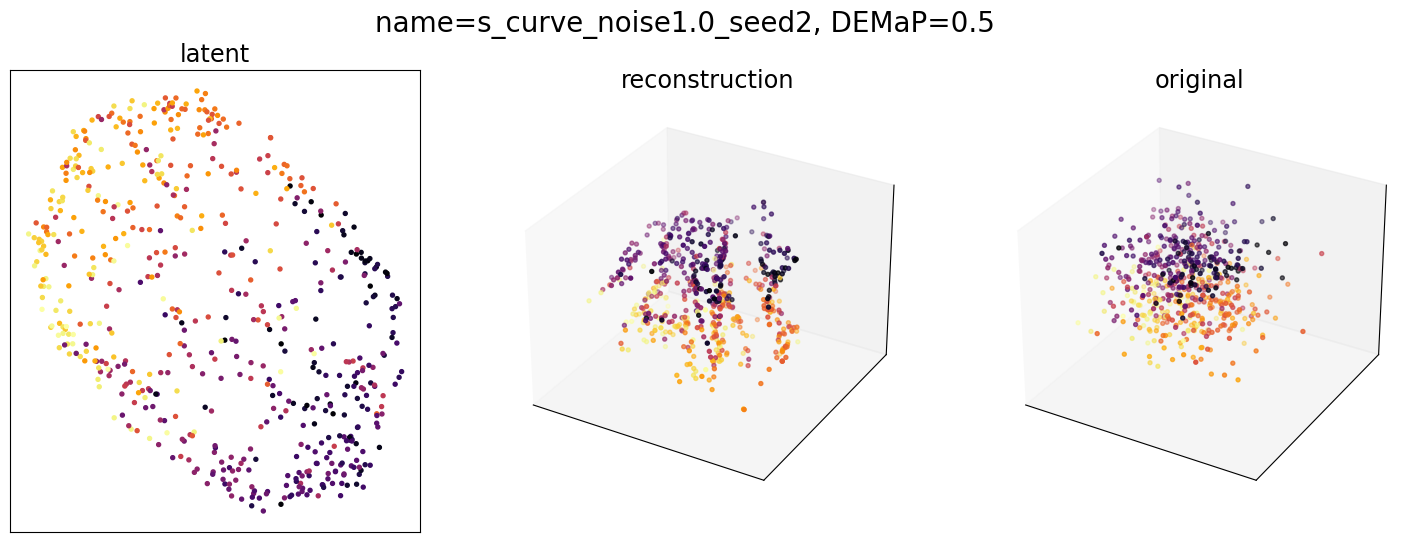

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


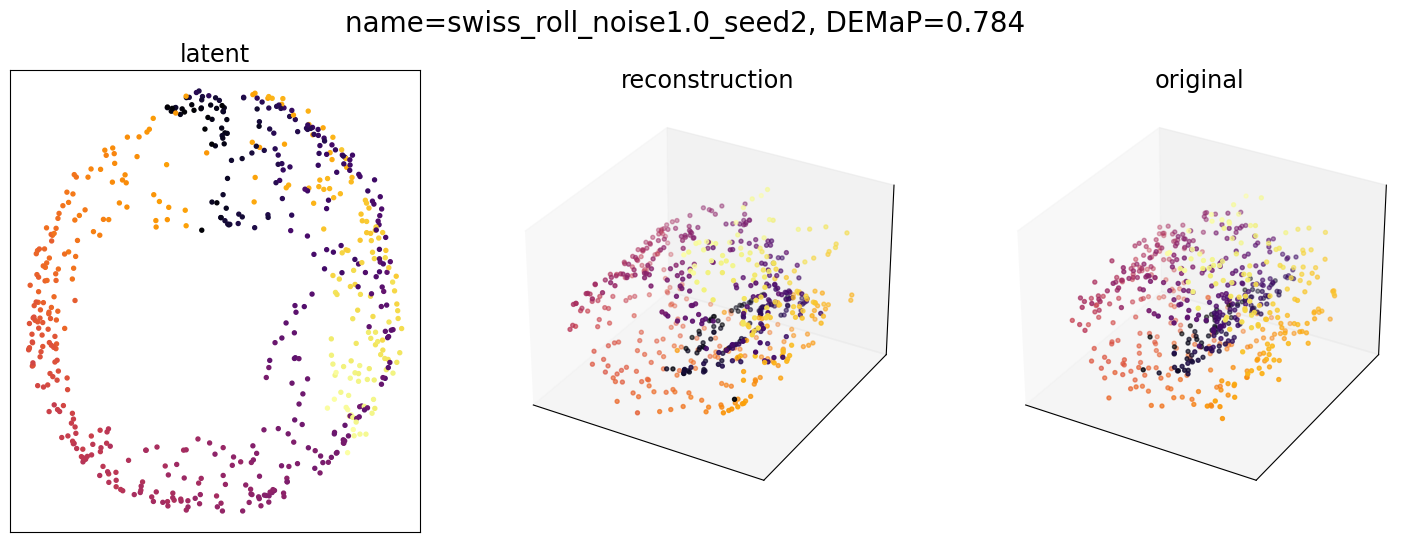

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


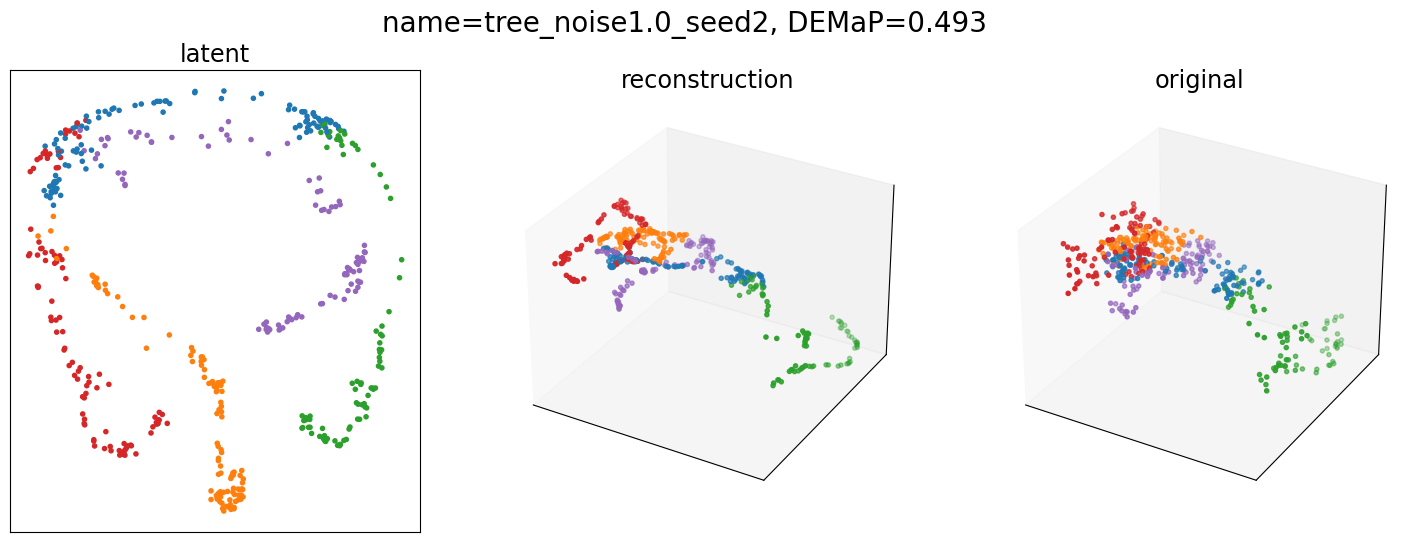

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


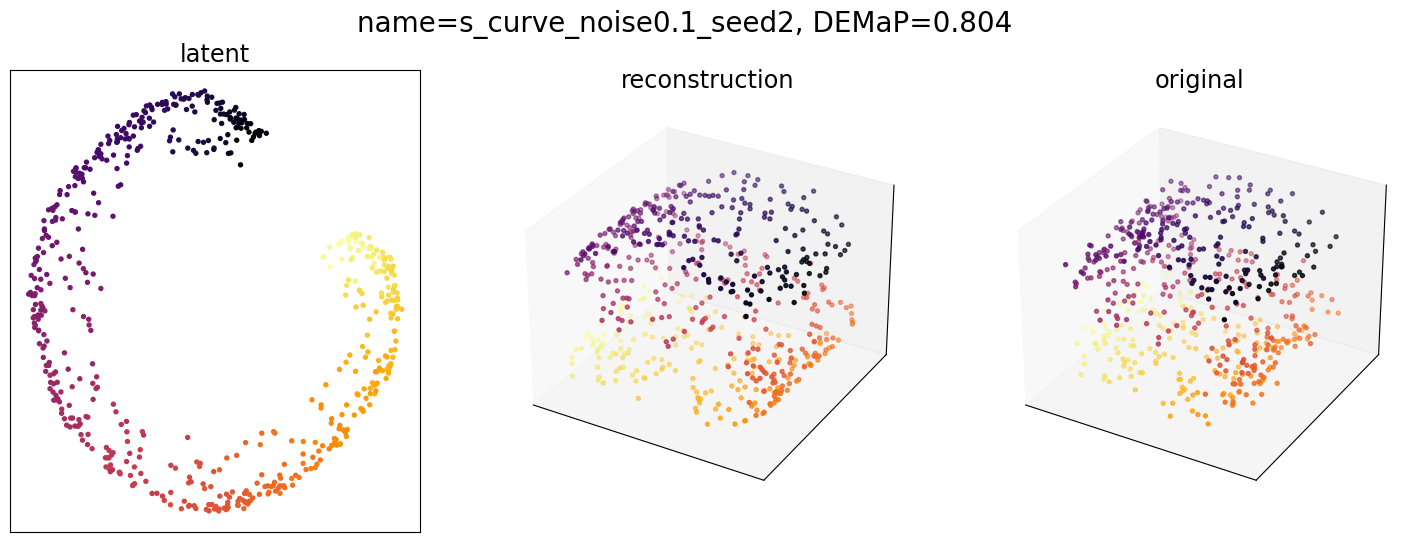

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


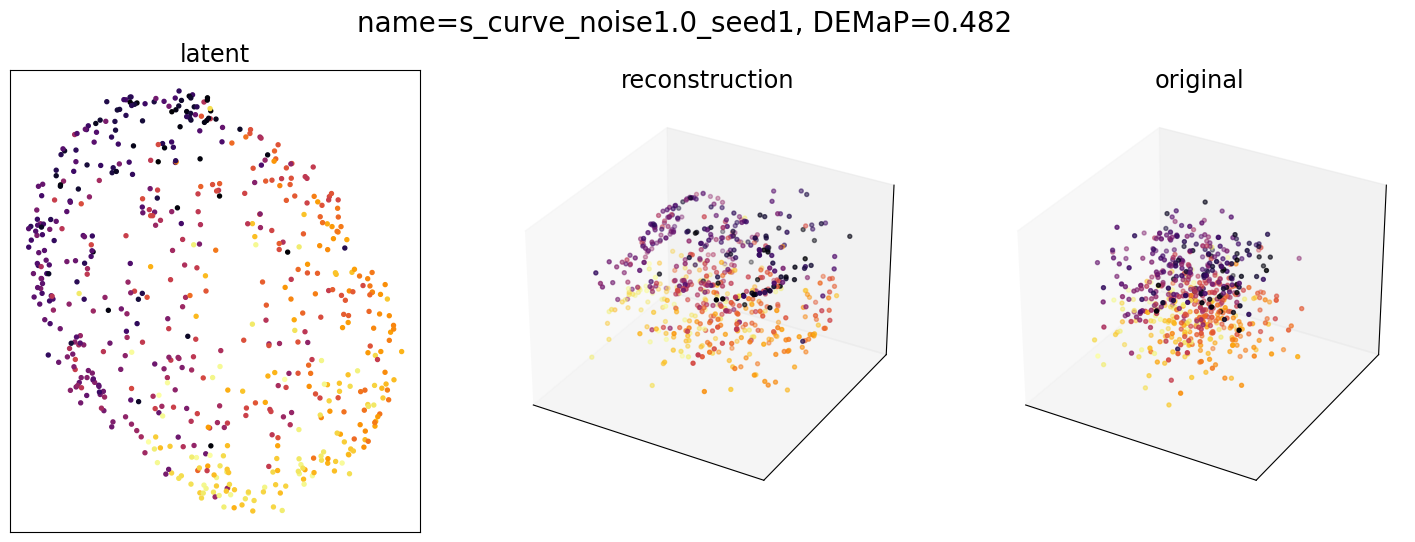

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


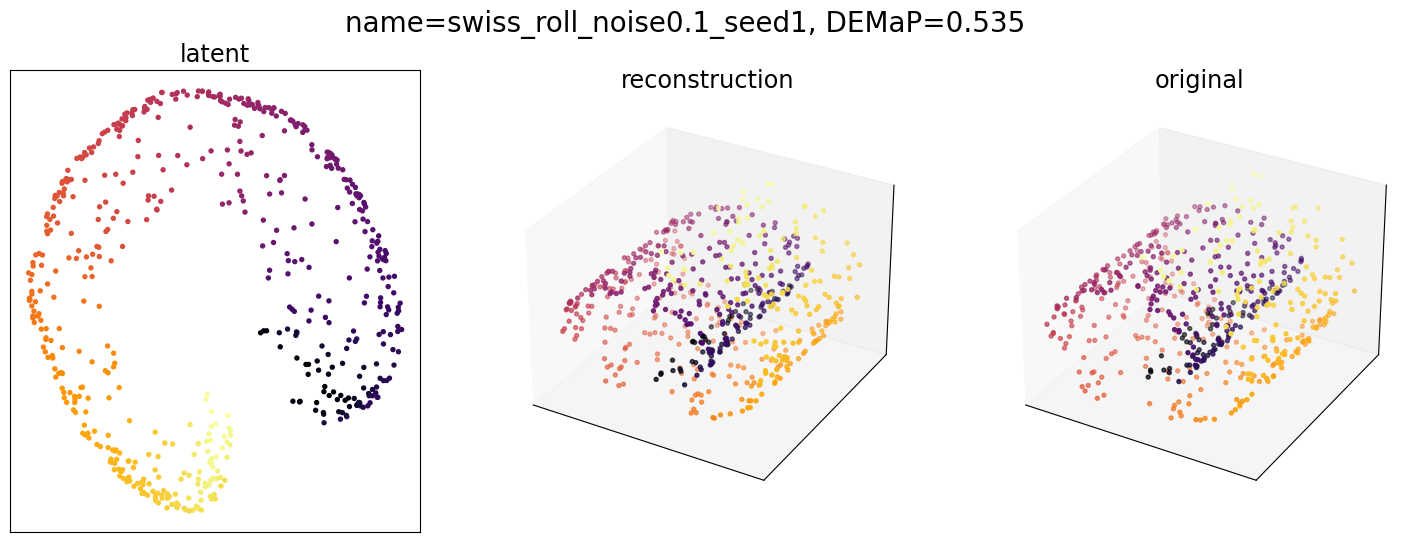

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


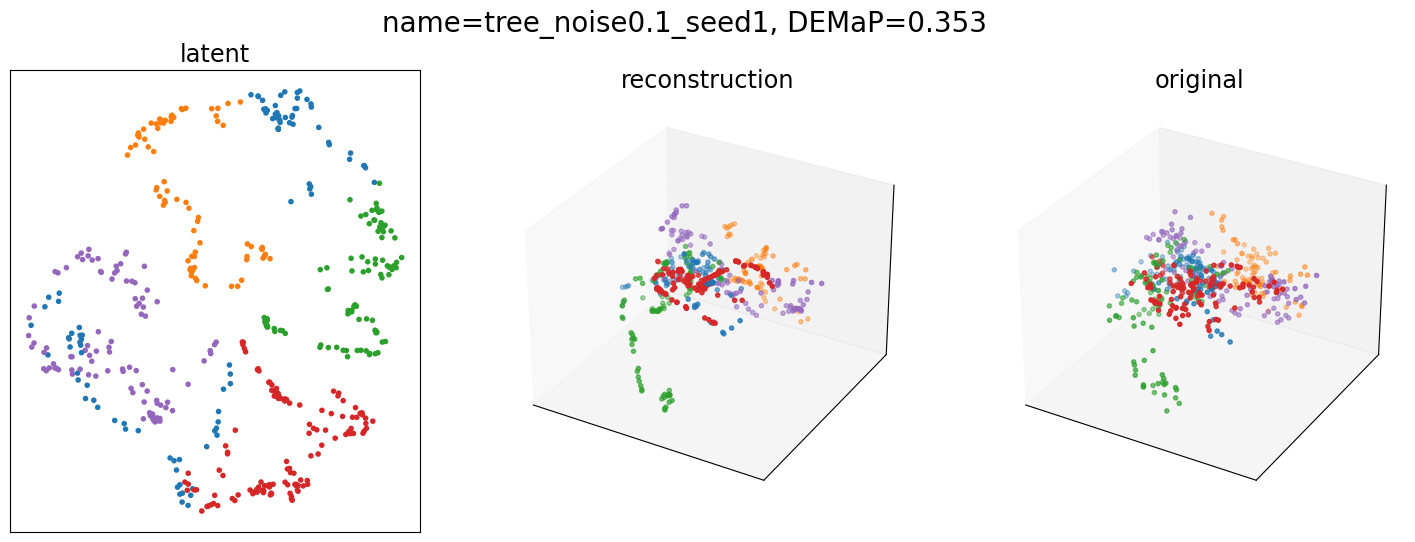

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


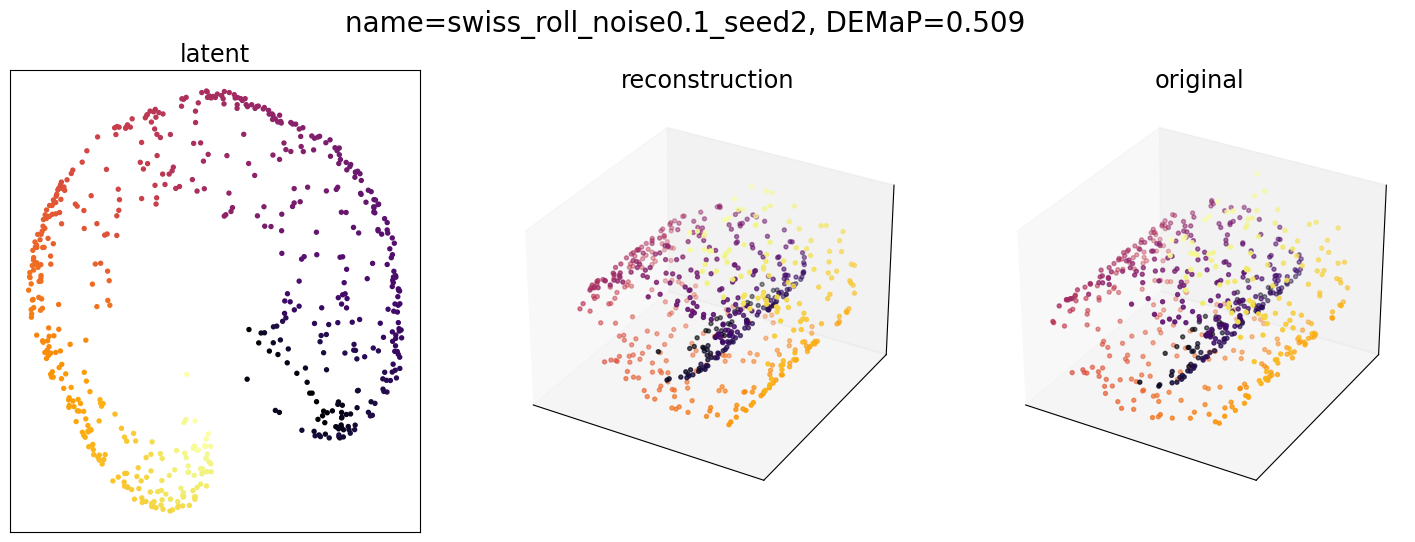

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


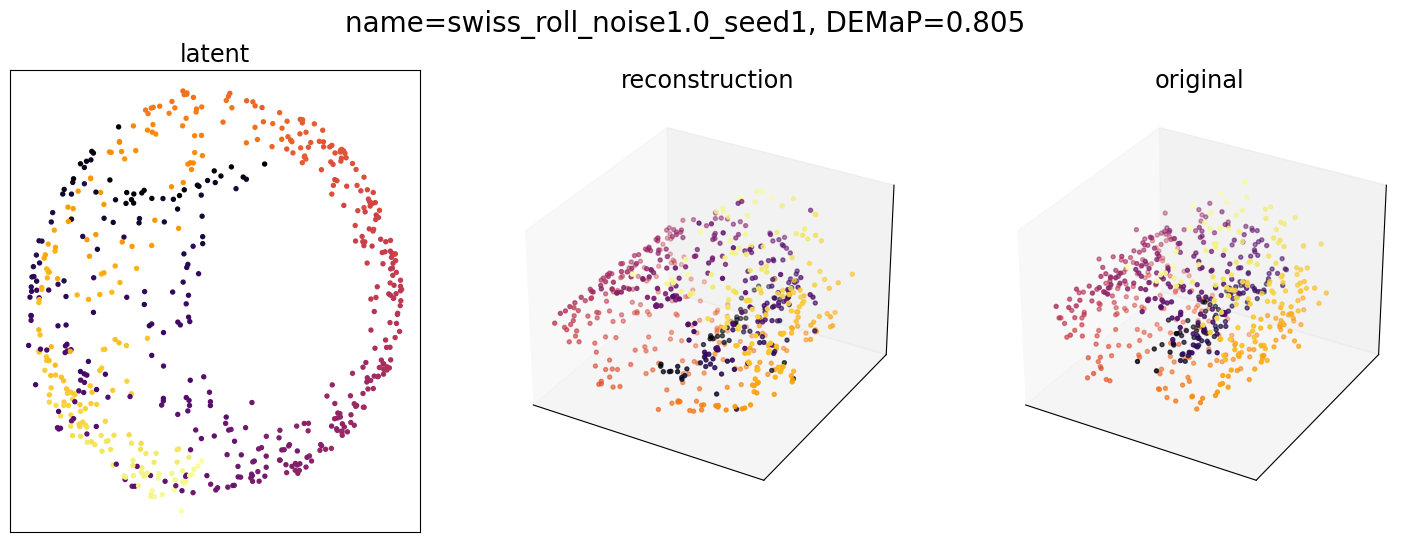

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


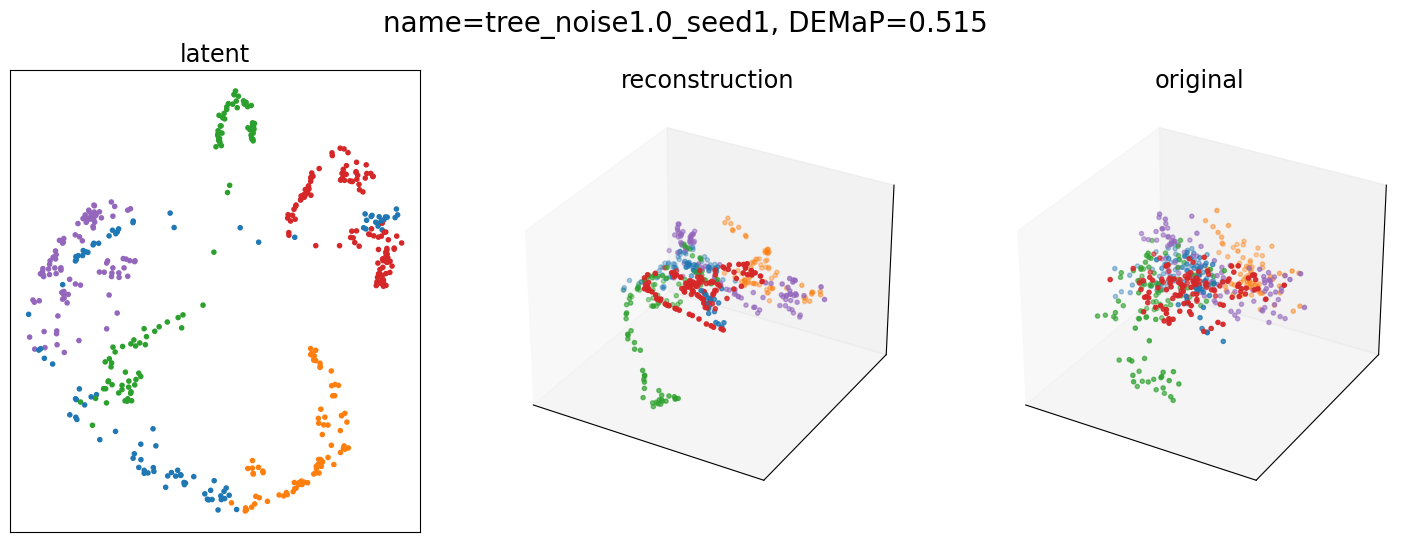

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


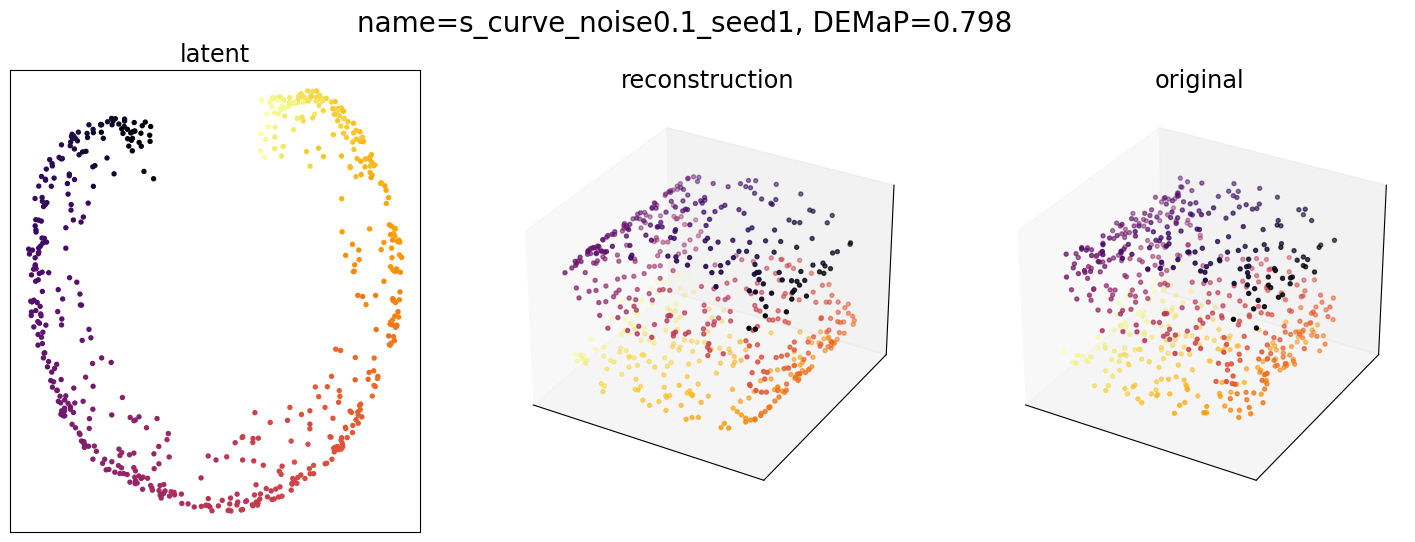

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


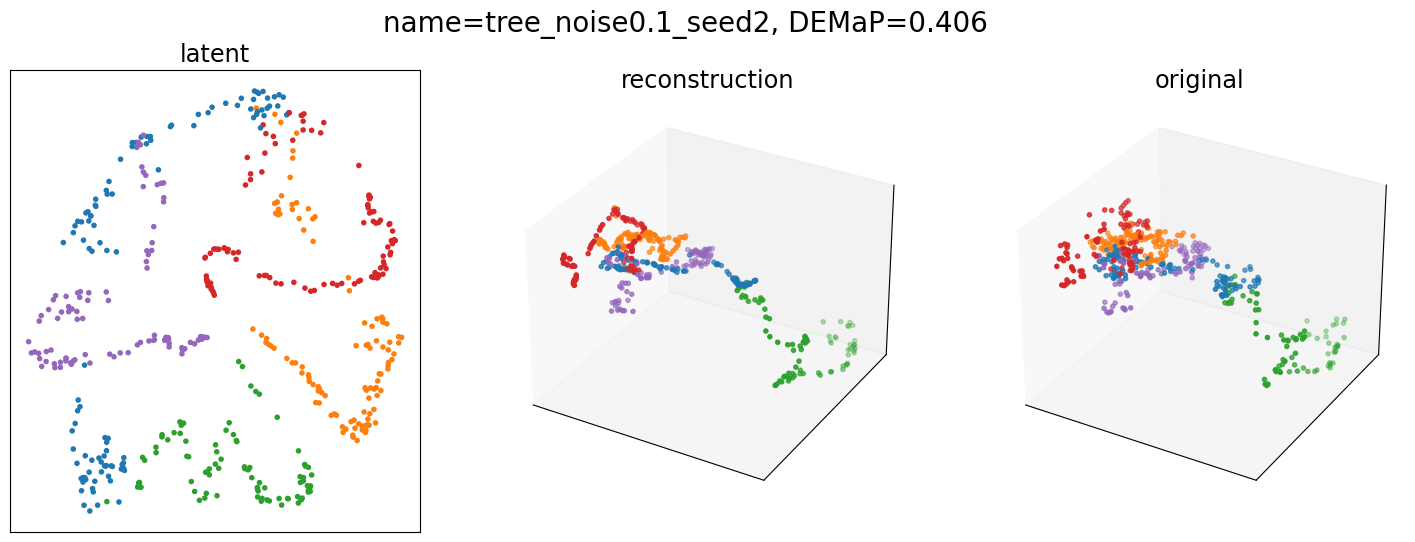

In [12]:
sweep_id = 'hwq180m8' # landmark on

sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
res = []
for run in sweep.runs:
    cfg = OmegaConf.create(run.config)
    folder_path = "../src/wandb/"
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
    data = np.load(data_path, allow_pickle=True)
    model = AEDist.load_from_checkpoint(ckpt_path)
    x_tensor = torch.tensor(data['data'][~data['is_train'].astype(bool)], dtype=torch.float32, device=model.device)
    colors = data['colors'][~data['is_train'].astype(bool)]
    x_true = data['data_gt'][~data['is_train'].astype(bool)]
    with torch.no_grad():
        z = model.encode(x_tensor)
        xh = model.decode(z)
    demap_val = demap.DEMaP(x_true, z.cpu().numpy())
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131)
    scprep.plot.scatter2d(z.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax1, title='latent')
    ax2 = fig.add_subplot(132, projection='3d')
    scprep.plot.scatter3d(xh.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax2, title='reconstruction')
    ax3 = fig.add_subplot(133, projection='3d')
    scprep.plot.scatter3d(x_tensor.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax3, title='original')
    plt.suptitle(f'name={cfg.data.name}, DEMaP={np.round(demap_val, 3)}', fontsize=20)
    plt.show()
    res_dict = dict(
        name=cfg.data.name,
        DEMaP=demap_val
    )
    res.append(res_dict)

In [13]:
import pandas as pd
res_df_60 = pd.DataFrame(res)
res_df_60.sort_values('name').to_csv('toy_res_landmark_off_t60.csv', index=False)